# **Code for Master's Thesis "EXPERIMENTAL EVALUATION OF TOKENIZATION STRATEGIES FOR LARGE LANGUAGE MODELS IN FINANCIAL TIME SERIES FORECASTING"**

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1Hug5-Zz2sMHq0vONGFTWEfJQ2jMareCa?usp=sharing)

**Overall Approach**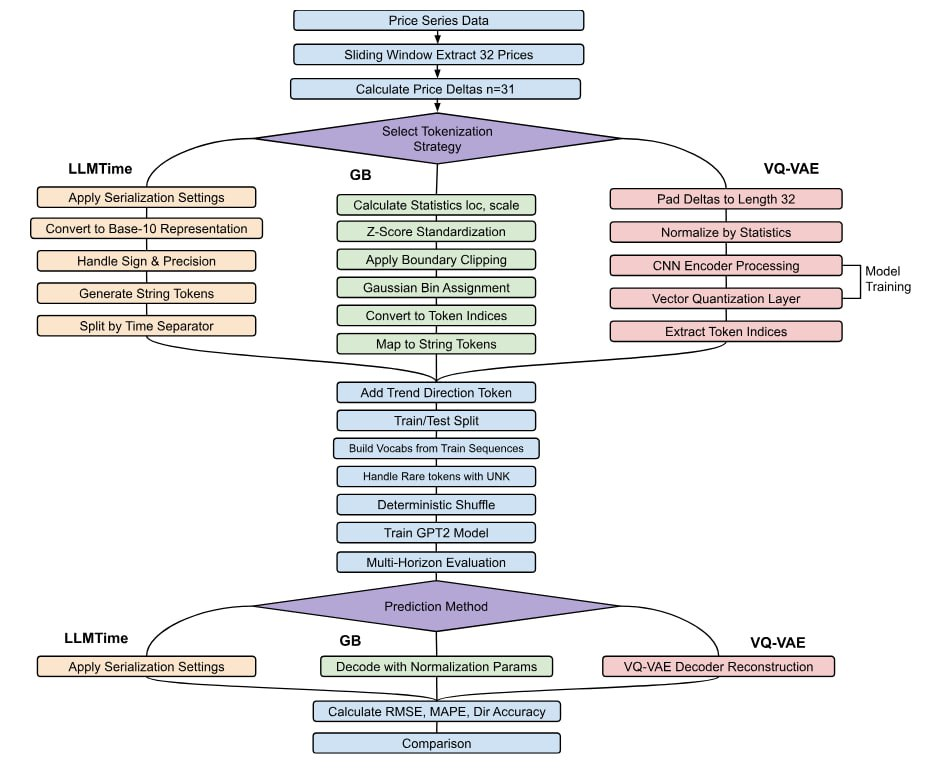

# **Agenda of the notebook**
CELL 1: Install dependencies + upload the file

CELL 2: Import necessary libraries + preprocess data

CELL 3: Install reproducibility utilities

CELL 4: Define shared GPT model components and training infrastructure

CELL 5: Define shared utilities for sequence processing and vocabulary construction

CELL 6: Define LLMTime numerical tokenization implementation (inpired by https://github.com/ngruver/llmtime)

CELL 7: Define Gaussian binning tokenization (inspired by https://github.com/arpytanshu/ts-tok)

CELL 8: Define VQ-VAE tokenization (inspired by https://github.com/SaberaTalukder/TOTEM)

CELLS 9: Define unified evaluation framework (9a - Define Evaluation Class, 9b - Add data preparation methods, 9c - Add prediction method, 9d - Add experiment execution methods, 9e - add analysis and reporting methods)

CELL 10: Define experimental configuration and setup

CELL 11: Run multi-method comparison

The development of this code was supported by AI assistance from ChatGPT and Claude.

**CELL 1: Install dependencies + upload the file**

In [1]:
# Install dependencies and upload data
# Need openpyxl for Excel file handling
!pip install openpyxl

# Upload the dataset files
from google.colab import files
print("Upload your raw data files (CSV and Excel):")
uploaded_files = files.upload()

Upload your raw data files (CSV and Excel):


Saving raw_data.csv to raw_data.csv


**CELL 2: Import necessary libraries + preprocess data**

In [2]:
# Import required libraries for data processing and model implementation
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.metrics import mean_squared_error, mean_absolute_error
import random
import os
from collections import Counter
from functools import partial
from dataclasses import dataclass
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Transformer architecture dependencies
from transformers import Trainer, TrainingArguments, GPT2Config, GPT2LMHeadModel
from transformers import DataCollatorForLanguageModeling, EarlyStoppingCallback
from tokenizers import Tokenizer as HFTokenizer
from tokenizers.models import WordLevel
from transformers import PreTrainedTokenizerFast
from datasets import Dataset

# Method-specific dependencies
from scipy.stats import norm  # Required for Gaussian binning implementation
import torch.nn.functional as F  # Required for VQ-VAE operations
from types import SimpleNamespace  # Configuration object handling

# Data loading and preprocessing
df = pd.read_csv("raw_data.csv", parse_dates=["Date"])
df = df[['Date', 'Price']]

# Data cleaning: remove formatting artifacts and ensure proper data types
df['Price'] = df['Price'].str.replace(',', '').astype(float)
df['Date'] = pd.to_datetime(df['Date'])

# Sort chronologically and reset index
df = df.sort_values('Date').reset_index(drop=True)

# Extract price series for model input
price_series = df['Price'].values

print(f"Data loaded successfully: {len(price_series)} observations")
print(f"Time period: {df['Date'].min().strftime('%Y-%m-%d')} to {df['Date'].max().strftime('%Y-%m-%d')}")

Data loaded successfully: 3774 observations
Time period: 2010-01-04 to 2024-12-31


**CELL 3: Install reproducibility utilities**

In [3]:
# Reproducibility and evaluation utilities

def set_global_seed(seed):
    """
    Configure all random number generators for reproducible results.
    Essential for ensuring consistent experimental outcomes across runs.
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    # Configure PyTorch for deterministic behavior
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.use_deterministic_algorithms(True, warn_only=True)

    # Set environment variables for complete reproducibility
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'
    os.environ['TRANSFORMERS_SEED'] = str(seed)

    print(f"Random seed initialized: {seed}")

def create_seeded_generator(seed):
    """
    Generate a dedicated random number generator with specified seed.
    Useful for maintaining separate random streams in different components.
    """
    rng = np.random.Generator(np.random.PCG64(seed))
    return rng

def calculate_directional_accuracy(actual_values, predicted_values):
    """
    Compute directional accuracy metric for time series predictions.
    Measures the percentage of correctly predicted price movement directions.
    """
    if len(actual_values) < 2 or len(predicted_values) < 2:
        return 50.0  # Return baseline accuracy for insufficient data

    actual_directions = np.sign(np.diff(actual_values))
    predicted_directions = np.sign(np.diff(predicted_values))

    accuracy = np.mean(actual_directions == predicted_directions) * 100
    return accuracy

# Initialize reproducibility settings
set_global_seed(42)

Random seed initialized: 42


**CELL 4: Define shared GPT model components and training infrastructure**

In [4]:
# Shared GPT model components and training infrastructure

def build_huggingface_tokenizer(vocabulary):
    """
    Construct a HuggingFace-compatible tokenizer from vocabulary.
    Uses word-level tokenization for financial time series representation.
    """
    tokenizer_base = HFTokenizer(WordLevel(vocabulary, unk_token="[UNK]"))
    tokenizer_base.normalizer = None
    tokenizer_base.pre_tokenizer = None

    tokenizer = PreTrainedTokenizerFast(
        tokenizer_object=tokenizer_base,
        unk_token="[UNK]",
        pad_token="<pad>",
        eos_token="<eos>",
        bos_token="<bos>"
    )
    return tokenizer

def initialize_gpt_model(vocabulary):
    """
    Initialize GPT-2 model with configuration optimized for financial sequences.
    Architecture parameters selected based on sequence length and vocabulary size.
    """
    model_config = GPT2Config(
        vocab_size=len(vocabulary),
        n_positions=64,           # Maximum sequence length
        n_embd=128,              # Embedding dimension
        n_layer=6,               # Number of transformer layers
        n_head=8,                # Number of attention heads
        pad_token_id=vocabulary["<pad>"],
        eos_token_id=vocabulary["<eos>"],
        bos_token_id=vocabulary["<bos>"],
        resid_pdrop=0.1,         # Residual dropout
        embd_pdrop=0.1,          # Embedding dropout
        attn_pdrop=0.1,          # Attention dropout
        use_cache=False,
        initializer_range=0.02
    )
    return GPT2LMHeadModel(model_config)

def configure_training_parameters(seed, output_directory, log_directory):
    """
    Define training hyperparameters and optimization settings.
    Configuration balances training efficiency with model performance.
    """
    return TrainingArguments(
        output_dir=output_directory,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        num_train_epochs=3,
        learning_rate=5e-4,
        weight_decay=0.01,
        warmup_steps=50,
        logging_dir=log_directory,
        save_total_limit=1,
        logging_steps=20,
        eval_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="eval_loss",
        report_to="none",
        seed=seed,
        data_seed=seed,
        dataloader_num_workers=0,
        remove_unused_columns=False,
        prediction_loss_only=True
    )

def train_transformer_model(sequence_data, vocabulary, random_seed, method_identifier):
    """
    Execute complete model training pipeline.
    Handles data preparation, model initialization, and training execution.
    """
    print(f"Initiating model training for {method_identifier} (seed: {random_seed})")

    # Ensure reproducible training conditions
    set_global_seed(random_seed)

    # Initialize model components
    tokenizer = build_huggingface_tokenizer(vocabulary)
    model = initialize_gpt_model(vocabulary)

    # Prepare training datasets
    training_dataset = Dataset.from_dict({"text": sequence_data['train']})
    validation_dataset = Dataset.from_dict({"text": sequence_data['eval']})

    def process_and_tokenize(batch):
        """Convert text sequences to tokenized format with labels."""
        input_ids_list = []
        labels_list = []

        for sequence in batch["text"]:
            tokens = sequence.split()
            if tokens:
                try:
                    tokenized = tokenizer(tokens, is_split_into_words=True, add_special_tokens=False)
                    if "input_ids" in tokenized and len(tokenized["input_ids"]) > 0:
                        input_ids_list.append(tokenized["input_ids"])
                        labels_list.append(tokenized["input_ids"])
                except:
                    continue

        return {"input_ids": input_ids_list, "labels": labels_list}

    # Apply tokenization to datasets
    train_tokenized = training_dataset.map(
        process_and_tokenize,
        batched=True,
        batch_size=100,
        remove_columns=["text"]
    )
    eval_tokenized = validation_dataset.map(
        process_and_tokenize,
        batched=True,
        batch_size=100,
        remove_columns=["text"]
    )

    # Shuffle training data for better optimization
    train_tokenized = train_tokenized.shuffle(seed=random_seed)

    # Configure training setup
    training_config = configure_training_parameters(
        random_seed,
        f"./gpt2_{method_identifier}_run_{random_seed}",
        f"./logs_{method_identifier}_run_{random_seed}"
    )

    data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)

    # Initialize trainer with early stopping
    trainer = Trainer(
        model=model,
        args=training_config,
        train_dataset=train_tokenized,
        eval_dataset=eval_tokenized,
        tokenizer=tokenizer,
        data_collator=data_collator,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
    )

    # Execute training process
    trainer.train()
    print(f"Model training completed successfully for {method_identifier}")

    return model, tokenizer

**CELL 5: Define shared utilities for sequence processing and vocabulary construction**

In [5]:
# Shared utilities for sequence processing and vocabulary construction

def construct_vocabulary(training_sequences, special_tokens=None, frequency_threshold=2):
    """
    Build vocabulary from training sequences with frequency filtering.
    Maintains consistent token-to-index mapping across different tokenization methods.
    """
    if special_tokens is None:
        special_tokens = {
            "<slope_-1>", "<slope_0>", "<slope_1>",
            "<pad>", "<eos>", "<bos>", "[UNK]", "NaN"
        }

    # Count token frequencies across all training sequences
    token_frequencies = Counter()
    for sequence in training_sequences:
        tokens = sequence.split()
        token_frequencies.update(tokens)

    # Filter tokens based on frequency threshold
    vocabulary_tokens = set()
    for token, frequency in token_frequencies.items():
        if token in special_tokens or frequency >= frequency_threshold:
            vocabulary_tokens.add(token)

    # Ensure all special tokens are included
    vocabulary_tokens.update(special_tokens)

    # Create deterministic vocabulary mapping
    vocabulary = {}
    for token in sorted(vocabulary_tokens):
        vocabulary[token] = len(vocabulary)

    return vocabulary

def handle_out_of_vocabulary_tokens(sequence, vocabulary, special_tokens):
    """
    Replace tokens not present in vocabulary with unknown token marker.
    Ensures all sequences contain only recognized vocabulary items.
    """
    tokens = sequence.split()
    processed_tokens = []

    for token in tokens:
        if token in vocabulary:
            processed_tokens.append(token)
        elif token in special_tokens:
            processed_tokens.append(token)
        else:
            processed_tokens.append("[UNK]")

    return " ".join(processed_tokens)

def determine_trend_direction(price_window, window_size):
    """
    Calculate trend direction token based on price movement slope.
    Categorizes trends into three discrete states for sequence modeling.
    """
    # Calculate linear trend slope over the window
    trend_slope = (price_window[-1] - price_window[0]) / window_size

    # Classify trend direction with threshold-based discretization
    if abs(trend_slope) < 0.1:  # Minimal change threshold
        return "<slope_0>"
    elif trend_slope > 0:
        return "<slope_1>"
    else:
        return "<slope_-1>"

def create_temporal_split(sequences, dataframe, window_length, seq_length):
    """
    Split sequences into training and evaluation sets using temporal cutoff.
    Ensures no data leakage by maintaining chronological order.
    """
    # Define temporal split point for out-of-sample evaluation
    split_date = pd.to_datetime('2022-01-01')

    # Find corresponding index in dataframe
    future_data = dataframe[dataframe['Date'] >= split_date]
    if len(future_data) > 0:
        split_index = future_data.index[0]
    else:
        split_index = len(dataframe)

    # Account for sequence generation requirements
    training_cutoff = max(0, split_index - window_length - seq_length)

    # Ensure sufficient evaluation data
    if training_cutoff >= len(sequences) - 50:
        training_cutoff = int(0.8 * len(sequences))

    # Create temporal split
    training_sequences = sequences[:training_cutoff]
    evaluation_sequences = sequences[training_cutoff:]

    return training_sequences, evaluation_sequences

**CELL 6: Define LLMTime numerical tokenization implementation (inpired by https://github.com/ngruver/llmtime)**

In [6]:
# LLMTime numerical tokenization implementation

@dataclass
class NumericSerializationConfig:
    """Configuration parameters for numerical sequence serialization."""
    base: int = 10
    precision: int = 3
    signed: bool = True
    fixed_length: bool = False
    max_value: float = 1e4
    time_separator: str = ' '
    bit_separator: str = ''
    positive_sign: str = ''
    negative_sign: str = '-'
    half_bin_correction: bool = True
    decimal_point: str = ''
    missing_value_token: str = 'NaN'

# ============================================================================
# Core numerical serialization functions
# ============================================================================

def convert_numbers_to_base_representation(values, base, precision, max_value):
    """
    Transform numerical values into specified base representation with given precision.
    Handles both integer and fractional components of the representation.
    """
    base = float(base)
    batch_size = values.shape[0]

    # Extract sign information
    sign_values = 1 * (values >= 0) - 1 * (values < 0)
    absolute_values = np.abs(values)

    # Calculate maximum bit position needed
    max_bit_position = int(np.ceil(np.log(max_value) / np.log(base)).item())

    # Process integer part (before decimal)
    integer_digits = []
    remaining_values = absolute_values.copy()

    for position in range(max_bit_position):
        current_power = max_bit_position - position - 1
        digit = (remaining_values / base**current_power).astype(int)
        integer_digits.append(digit)
        remaining_values -= digit * base**current_power

    integer_part = np.stack(integer_digits, axis=-1)

    # Process fractional part if precision > 0
    if precision > 0:
        fractional_digits = []
        for position in range(precision):
            current_power = -position - 1
            digit = (remaining_values / base**current_power).astype(int)
            fractional_digits.append(digit)
            remaining_values -= digit * base**current_power

        fractional_part = np.stack(fractional_digits, axis=-1)
        all_digits = np.concatenate([integer_part, fractional_part], axis=-1)
    else:
        all_digits = integer_part

    return sign_values, all_digits

def convert_base_representation_to_numbers(signs, digits, base, precision, apply_half_bin_correction=True):
    """
    Convert base representation back to numerical values.
    Applies half-bin correction for improved accuracy if specified.
    """
    base = float(base)
    batch_size, num_digits = digits.shape

    # Reverse digit order for power calculation
    reversed_digits = np.flip(digits, axis=-1)
    power_exponents = -np.arange(-precision, -precision + num_digits)

    # Calculate numerical value from base representation
    numerical_values = np.sum(reversed_digits / base**power_exponents, axis=-1)

    # Apply half-bin correction for better reconstruction accuracy
    if apply_half_bin_correction:
        numerical_values += 0.5 / base**precision

    return signs * numerical_values

def serialize_numerical_array(input_array, config):
    """
    Convert numerical array to string representation using specified configuration.
    Handles missing values and applies formatting rules consistently.
    """
    # Validate input constraints
    valid_mask = ~np.isnan(input_array)
    assert np.all(np.abs(input_array[valid_mask]) <= config.max_value)

    # Configure sign handling
    if not config.signed:
        assert np.all(input_array[valid_mask] >= 0)
        positive_marker = negative_marker = ''
    else:
        positive_marker = config.positive_sign
        negative_marker = config.negative_sign

    # Convert to base representation
    conversion_function = partial(
        convert_numbers_to_base_representation,
        base=config.base,
        precision=config.precision,
        max_value=config.max_value
    )

    signs, digits = conversion_function(np.where(np.isnan(input_array), np.zeros_like(input_array), input_array))
    missing_mask = np.isnan(input_array)

    def format_digit_sequence(digit_array):
        """Convert digit array to string with specified separators."""
        return ''.join([config.bit_separator + str(digit) for digit in digit_array])

    # Process each number in the array
    formatted_strings = []
    for sign, digit_sequence, is_missing in zip(signs, digits, missing_mask):
        if not config.fixed_length:
            # Remove leading zeros for variable length representation
            nonzero_positions = np.where(digit_sequence != 0)[0]
            if len(nonzero_positions) == 0:
                digit_sequence = np.array([0])
            else:
                digit_sequence = digit_sequence[nonzero_positions[0]:]

        # Add decimal point if specified
        if len(config.decimal_point):
            decimal_position = len(digit_sequence) - config.precision
            digit_sequence = np.concatenate([
                digit_sequence[:decimal_position],
                np.array([config.decimal_point]),
                digit_sequence[decimal_position:]
            ])

        # Format digits and add sign
        formatted_digits = format_digit_sequence(digit_sequence)
        sign_marker = positive_marker if sign == 1 else negative_marker

        # Handle missing values
        if is_missing:
            formatted_strings.append(config.missing_value_token)
        else:
            formatted_strings.append(sign_marker + formatted_digits)

    # Join all formatted numbers
    result_string = config.time_separator.join(formatted_strings)
    result_string += config.time_separator

    return result_string

def deserialize_string_to_array(input_string, config, ignore_final_token=False, max_steps=None):
    """
    Convert string representation back to numerical array.
    Handles parsing errors gracefully and maintains data integrity.
    """
    original_string = input_string
    string_tokens = input_string.split(config.time_separator)
    string_tokens = [token for token in string_tokens if len(token) > 0]

    # Apply processing options
    if ignore_final_token:
        string_tokens = string_tokens[:-1]
    if max_steps is not None:
        string_tokens = string_tokens[:max_steps]

    # Configure conversion function
    conversion_function = partial(
        convert_base_representation_to_numbers,
        base=config.base,
        precision=config.precision,
        apply_half_bin_correction=config.half_bin_correction
    )

    max_bit_position = int(np.ceil(np.log(config.max_value) / np.log(config.base)).item())

    parsed_signs = []
    parsed_digits = []

    try:
        for token_index, token_string in enumerate(string_tokens):
            # Parse sign information
            if token_string.startswith(config.negative_sign):
                current_sign = -1
                token_string = token_string[len(config.negative_sign):]
            elif token_string.startswith(config.positive_sign):
                current_sign = 1
                token_string = token_string[len(config.positive_sign):]
            else:
                current_sign = 1

            # Extract individual digits
            if config.bit_separator == '':
                bit_characters = [char for char in token_string.lstrip()]
            else:
                bit_characters = [char[:1] for char in token_string.lstrip().split(config.bit_separator)]

            # Convert characters to digits
            current_digits = []
            for character in bit_characters:
                if character == config.decimal_point:
                    continue
                if character.isdigit():
                    current_digits.append(int(character))
                else:
                    break

            parsed_signs.append(current_sign)
            parsed_digits.append(current_digits)

    except Exception as parsing_error:
        print(f"Parsing error encountered: {parsing_error}")
        if parsed_digits:
            # Pad sequences to same length and convert
            max_length = max([len(digits) for digits in parsed_digits])
            for i in range(len(parsed_digits)):
                padding_needed = max_length - len(parsed_digits[i])
                parsed_digits[i] = [0] * padding_needed + parsed_digits[i]
            return conversion_function(np.array(parsed_signs), np.array(parsed_digits))
        else:
            return None

    # Convert parsed data to numerical array
    if parsed_digits:
        max_length = max([len(digits) for digits in parsed_digits])
        for i in range(len(parsed_digits)):
            padding_needed = max_length - len(parsed_digits[i])
            parsed_digits[i] = [0] * padding_needed + parsed_digits[i]
        return conversion_function(np.array(parsed_signs), np.array(parsed_digits))
    else:
        return None

def apply_llmtime_tokenization(delta_values, serialization_config):
    """
    Apply LLMTime-specific tokenization to price delta sequences.
    Converts numerical deltas to discrete tokens for language model processing.
    """
    serialized_sequence = serialize_numerical_array(delta_values, serialization_config)

    if serialization_config.time_separator in serialized_sequence:
        serialized_sequence = serialized_sequence.rstrip(serialization_config.time_separator)
        token_list = serialized_sequence.split(serialization_config.time_separator)
    else:
        token_list = [serialized_sequence]

    return [token.strip() for token in token_list if token.strip()]

def reverse_llmtime_tokenization(token_list, serialization_config):
    """
    Convert tokenized sequence back to numerical delta values.
    Reverses the LLMTime tokenization process for model output interpretation.
    """
    reconstructed_string = serialization_config.time_separator.join(token_list) + serialization_config.time_separator
    return deserialize_string_to_array(reconstructed_string, serialization_config)

**CELL 7: Define Gaussian binning tokenization (inspired by https://github.com/arpytanshu/ts-tok)**

In [7]:
# Gaussian binning tokenization for statistical distribution modeling

class GaussianBinningTokenizer:
    """
    Implements Gaussian-based binning for converting continuous values to discrete tokens.
    Uses statistical properties of normal distribution for optimal bin placement.
    """

    def __init__(self, configuration, random_seed=None):
        self.bin_size = configuration.bin_size
        self.max_coverage = configuration.max_coverage
        self.random_seed = random_seed

        # Initialize deterministic bin generation if seed provided
        if random_seed is not None:
            set_global_seed(random_seed)

        self.bin_boundaries, self.bin_centers = self._create_gaussian_bins(
            self.bin_size, self.max_coverage
        )

        print(f"Gaussian binning initialized: {len(self.bin_boundaries)} bins (seed: {random_seed})")

    @staticmethod
    def _create_gaussian_bins(bin_size, max_coverage):
        """
        Generate bin boundaries based on Gaussian distribution properties.
        Creates symmetric bins with equal probability mass for optimal tokenization.
        """
        standard_normal = norm(loc=0, scale=1)

        def calculate_next_boundary(current_point, bin_size):
            """Calculate next bin boundary maintaining equal probability mass."""
            target_cdf = np.clip(standard_normal.cdf(current_point) + bin_size, 0, 0.99999)
            return standard_normal.ppf(target_cdf)

        # Generate positive side bins starting from zero
        positive_boundaries = [0]
        current_coverage = 0

        while current_coverage < max_coverage / 2:
            next_boundary = calculate_next_boundary(positive_boundaries[-1], bin_size)
            positive_boundaries.append(next_boundary)
            current_coverage = standard_normal.cdf(next_boundary) - standard_normal.cdf(0)

        # Create symmetric bin structure
        negative_boundaries = [-boundary for boundary in positive_boundaries[1:][::-1]]
        all_boundaries = np.array(negative_boundaries + positive_boundaries)

        # Calculate bin center points for decoding
        bin_center_points = 0.5 * (all_boundaries[:-1] + all_boundaries[1:])

        return all_boundaries, bin_center_points

    @staticmethod
    def standardize_values(values, location, scale):
        """Apply z-score standardization to input values."""
        return ((values.T - location) / (scale + 1e-6)).T

    @staticmethod
    def destandardize_values(values, location, scale):
        """Reverse z-score standardization to original scale."""
        return (values.T * scale + 1e-6).T + location

    def apply_boundary_clipping(self, values):
        """Ensure values fall within valid bin range to prevent overflow."""
        return np.clip(values, self.bin_boundaries[0] + 1e-3, self.bin_boundaries[-1] - 1e-3)

    def encode_to_tokens(self, input_values, normalization_params=None):
        """
        Convert continuous values to discrete token indices.
        Applies standardization and binning for optimal representation.
        """
        if not isinstance(input_values, np.ndarray):
            input_values = np.array(input_values)

        # Calculate normalization parameters if not provided
        if normalization_params is None:
            if input_values.ndim == 1:
                normalization_params = {
                    'location': input_values.mean(),
                    'scale': input_values.std()
                }
            elif input_values.ndim == 2:
                normalization_params = {
                    'location': input_values.mean(axis=1),
                    'scale': input_values.std(axis=1)
                }
            else:
                raise ValueError('Input must be 1-dimensional or 2-dimensional array')

        # Apply standardization and binning
        standardized_values = self.standardize_values(input_values, **normalization_params)
        clipped_values = self.apply_boundary_clipping(standardized_values)

        # Convert to discrete token indices
        token_indices = np.clip(
            np.digitize(clipped_values, self.bin_boundaries, right=False) - 1,
            0, len(self.bin_boundaries) - 2
        )

        return token_indices, normalization_params

    def decode_from_tokens(self, token_indices, normalization_params):
        """
        Convert discrete token indices back to continuous values.
        Uses bin centers and reverse standardization for reconstruction.
        """
        if not isinstance(token_indices, np.ndarray):
            token_indices = np.array(token_indices)

        # Map token indices to bin center values
        continuous_values = self.bin_centers[token_indices]

        # Apply reverse standardization
        return self.destandardize_values(continuous_values, **normalization_params)

def apply_gaussian_binning_tokenization(delta_values, binning_tokenizer):
    """
    Apply Gaussian binning tokenization to price delta sequences.
    Returns string tokens and normalization parameters for reconstruction.
    """
    # Calculate normalization parameters from data statistics
    normalization_params = {
        'location': delta_values.mean(),
        'scale': delta_values.std()
    }

    # Encode values to discrete tokens
    token_indices, _ = binning_tokenizer.encode_to_tokens(delta_values, normalization_params)

    # Convert to string representation
    string_tokens = list(map(str, token_indices))

    return string_tokens, normalization_params

def reverse_gaussian_binning_tokenization(token_strings, binning_tokenizer, normalization_params):
    """
    Convert tokenized sequence back to continuous delta values.
    Handles parsing errors gracefully with fallback values.
    """
    try:
        # Parse string tokens to integer indices
        token_indices = [int(token) for token in token_strings]

        # Decode to continuous values
        reconstructed_values = binning_tokenizer.decode_from_tokens(token_indices, normalization_params)

        return reconstructed_values
    except Exception:
        # Return zeros as fallback for parsing errors
        return [0.0] * len(token_strings)

**CELL 8: Define VQ-VAE tokenization (inspired by https://github.com/SaberaTalukder/TOTEM)**

In [8]:
# VQ-VAE implementation for neural vector quantization of time series

class ResidualBlock(nn.Module):
    """
    Residual connection block for convolutional neural networks.
    Implements skip connections to facilitate gradient flow in deep architectures.
    """
    def __init__(self, input_channels, hidden_units, residual_hidden_units):
        super(ResidualBlock, self).__init__()
        self.residual_path = nn.Sequential(
            nn.ReLU(True),
            nn.Conv1d(in_channels=input_channels,
                      out_channels=residual_hidden_units,
                      kernel_size=3, stride=1, padding=1, bias=False),
            nn.ReLU(True),
            nn.Conv1d(in_channels=residual_hidden_units,
                      out_channels=hidden_units,
                      kernel_size=1, stride=1, bias=False)
        )

    def forward(self, input_tensor):
        return input_tensor + self.residual_path(input_tensor)

class ResidualStack(nn.Module):
    """
    Stack of residual blocks for deep feature extraction.
    Enables training of deeper networks through residual connections.
    """
    def __init__(self, input_channels, hidden_units, num_residual_layers, residual_hidden_units):
        super(ResidualStack, self).__init__()
        self.num_layers = num_residual_layers
        self.residual_layers = nn.ModuleList([
            ResidualBlock(input_channels, hidden_units, residual_hidden_units)
            for _ in range(self.num_layers)
        ])

    def forward(self, input_tensor):
        current_tensor = input_tensor
        for layer_idx in range(self.num_layers):
            current_tensor = self.residual_layers[layer_idx](current_tensor)
        return F.relu(current_tensor)

class ConvolutionalEncoder(nn.Module):
    """
    Encoder network for compressing input sequences into latent representations.
    Uses strided convolutions for dimensionality reduction and feature extraction.
    """
    def __init__(self, input_channels, hidden_units, num_residual_layers,
                 residual_hidden_units, embedding_dimension, compression_ratio):
        super(ConvolutionalEncoder, self).__init__()

        if compression_ratio == 4:
            # First downsampling layer
            self.conv_layer_1 = nn.Conv1d(in_channels=input_channels,
                                         out_channels=hidden_units // 2,
                                         kernel_size=4,
                                         stride=2, padding=1)
            # Second downsampling layer
            self.conv_layer_2 = nn.Conv1d(in_channels=hidden_units // 2,
                                         out_channels=hidden_units,
                                         kernel_size=4,
                                         stride=2, padding=1)
            # Feature refinement layer
            self.conv_layer_3 = nn.Conv1d(in_channels=hidden_units,
                                         out_channels=hidden_units,
                                         kernel_size=3,
                                         stride=1, padding=1)
            # Residual processing stack
            self.residual_processing = ResidualStack(input_channels=hidden_units,
                                                   hidden_units=hidden_units,
                                                   num_residual_layers=num_residual_layers,
                                                   residual_hidden_units=residual_hidden_units)
            # Pre-quantization projection
            self.pre_quantization_conv = nn.Conv1d(in_channels=hidden_units,
                                                  out_channels=embedding_dimension,
                                                  kernel_size=1, stride=1)

    def forward(self, input_data, compression_ratio):
        if compression_ratio == 4:
            # Reshape input for 1D convolution
            processed_input = input_data.view([input_data.shape[0], 1, input_data.shape[-1]])

            # Apply sequential convolution layers
            feature_map = self.conv_layer_1(processed_input)
            feature_map = F.relu(feature_map)
            feature_map = self.conv_layer_2(feature_map)
            feature_map = F.relu(feature_map)
            feature_map = self.conv_layer_3(feature_map)

            # Process through residual stack
            feature_map = self.residual_processing(feature_map)

            # Final projection for quantization
            encoded_output = self.pre_quantization_conv(feature_map)
            return encoded_output

class ConvolutionalDecoder(nn.Module):
    """
    Decoder network for reconstructing sequences from quantized representations.
    Uses transposed convolutions for upsampling and signal reconstruction.
    """
    def __init__(self, input_channels, hidden_units, num_residual_layers,
                 residual_hidden_units, compression_ratio):
        super(ConvolutionalDecoder, self).__init__()

        if compression_ratio == 4:
            # Initial processing layer
            self.conv_layer_1 = nn.Conv1d(in_channels=input_channels,
                                         out_channels=hidden_units,
                                         kernel_size=3,
                                         stride=1, padding=1)
            # Residual feature processing
            self.residual_processing = ResidualStack(input_channels=hidden_units,
                                                   hidden_units=hidden_units,
                                                   num_residual_layers=num_residual_layers,
                                                   residual_hidden_units=residual_hidden_units)
            # First upsampling layer
            self.transposed_conv_1 = nn.ConvTranspose1d(in_channels=hidden_units,
                                                       out_channels=hidden_units // 2,
                                                       kernel_size=4,
                                                       stride=2, padding=1)
            # Final reconstruction layer
            self.transposed_conv_2 = nn.ConvTranspose1d(in_channels=hidden_units // 2,
                                                       out_channels=1,
                                                       kernel_size=4,
                                                       stride=2, padding=1)

    def forward(self, quantized_input, compression_ratio):
        if compression_ratio == 4:
            # Initial feature processing
            processed_features = self.conv_layer_1(quantized_input)
            processed_features = self.residual_processing(processed_features)

            # Upsampling and reconstruction
            upsampled = self.transposed_conv_1(processed_features)
            upsampled = F.relu(upsampled)
            reconstructed = self.transposed_conv_2(upsampled)

            return torch.squeeze(reconstructed)

class VectorQuantizationLayer(nn.Module):
    """
    Vector quantization module for discrete representation learning.
    Implements learnable codebook with commitment loss for stable training.
    """
    def __init__(self, codebook_size, embedding_dimension, commitment_coefficient):
        super(VectorQuantizationLayer, self).__init__()
        self.embedding_dimension = embedding_dimension
        self.codebook_size = codebook_size

        # Initialize learnable codebook
        self.codebook = nn.Embedding(self.codebook_size, self.embedding_dimension)
        self.codebook.weight.data.uniform_(-1 / self.codebook_size, 1 / self.codebook_size)
        self.commitment_coefficient = commitment_coefficient

    def forward(self, encoder_output):
        # Reshape for distance computation
        encoder_output = encoder_output.permute(0, 2, 1).contiguous()
        input_shape = encoder_output.shape
        flattened_input = encoder_output.view(-1, self.embedding_dimension)

        # Calculate distances to codebook vectors
        input_squared = torch.sum(flattened_input ** 2, dim=1, keepdim=True)
        codebook_squared = torch.sum(self.codebook.weight ** 2, dim=1)
        cross_terms = 2 * torch.matmul(flattened_input, self.codebook.weight.t())

        distances = input_squared + codebook_squared - cross_terms

        # Find nearest codebook entries
        nearest_indices = torch.argmin(distances, dim=1).unsqueeze(1)
        one_hot_encodings = torch.zeros(nearest_indices.shape[0], self.codebook_size, device=encoder_output.device)
        one_hot_encodings.scatter_(1, nearest_indices, 1)

        # Quantize using nearest codebook vectors
        quantized_output = torch.matmul(one_hot_encodings, self.codebook.weight).view(input_shape)

        # Calculate quantization losses
        encoder_loss = F.mse_loss(quantized_output.detach(), encoder_output)
        commitment_loss = F.mse_loss(quantized_output, encoder_output.detach())
        total_vq_loss = commitment_loss + self.commitment_coefficient * encoder_loss

        # Straight-through estimator for gradients
        quantized_output = encoder_output + (quantized_output - encoder_output).detach()

        # Calculate codebook utilization metrics
        average_probabilities = torch.mean(one_hot_encodings, dim=0)
        perplexity_measure = torch.exp(-torch.sum(average_probabilities * torch.log(average_probabilities + 1e-10)))

        return (total_vq_loss, quantized_output.permute(0, 2, 1).contiguous(),
                perplexity_measure, self.codebook.weight, nearest_indices, one_hot_encodings)

class VQVAEModel(nn.Module):
    """
    Complete VQ-VAE implementation for time series vector quantization.
    Combines encoder, vector quantization, and decoder for discrete representation learning.
    """
    def __init__(self, model_configuration, random_seed=None):
        super().__init__()

        # Initialize with deterministic seed if provided
        if random_seed is not None:
            set_global_seed(random_seed)

        # Extract configuration parameters
        hidden_units = model_configuration['block_hidden_size']
        num_residual_layers = model_configuration['num_residual_layers']
        residual_hidden_units = model_configuration['res_hidden_size']
        embedding_dimension = model_configuration['embedding_dim']
        codebook_size = model_configuration['num_embeddings']
        commitment_coefficient = model_configuration['commitment_cost']
        self.compression_ratio = model_configuration['compression_factor']

        # Initialize model components
        self.vector_quantizer = VectorQuantizationLayer(codebook_size, embedding_dimension, commitment_coefficient)
        self.encoder_network = ConvolutionalEncoder(1, hidden_units, num_residual_layers,
                                                   residual_hidden_units, embedding_dimension, self.compression_ratio)
        self.decoder_network = ConvolutionalDecoder(embedding_dimension, hidden_units, num_residual_layers,
                                                   residual_hidden_units, self.compression_ratio)

        print(f"VQ-VAE model initialized with seed: {random_seed}")

    def forward(self, input_batch):
        # Encode input to latent representation
        latent_encoding = self.encoder_network(input_batch, self.compression_ratio)

        # Apply vector quantization
        (quantization_loss, quantized_latent, perplexity_score,
         codebook_weights, encoding_indices, one_hot_encodings) = self.vector_quantizer(latent_encoding)

        # Decode quantized representation
        reconstructed_data = self.decoder_network(quantized_latent, self.compression_ratio)

        # Calculate reconstruction loss
        reconstruction_error = F.mse_loss(reconstructed_data, input_batch)
        total_loss = reconstruction_error + quantization_loss

        return (total_loss, quantization_loss, reconstruction_error, reconstructed_data,
                perplexity_score, codebook_weights, encoding_indices, one_hot_encodings)

    def encode_to_discrete_tokens(self, input_batch):
        """Convert continuous input to discrete token indices."""
        with torch.no_grad():
            latent_encoding = self.encoder_network(input_batch, self.compression_ratio)
            _, _, _, _, encoding_indices, _ = self.vector_quantizer(latent_encoding)
            return encoding_indices.squeeze()

    def decode_discrete_tokens(self, token_indices, target_shape):
        """Reconstruct continuous values from discrete token indices."""
        with torch.no_grad():
            # Map token indices to codebook embeddings
            token_embeddings = self.vector_quantizer.codebook(token_indices)

            # Reshape for decoder input
            if len(token_embeddings.shape) == 2:
                token_embeddings = token_embeddings.unsqueeze(0)
            token_embeddings = token_embeddings.permute(0, 2, 1)

            # Decode to continuous values
            reconstructed_sequence = self.decoder_network(token_embeddings, self.compression_ratio)
            return reconstructed_sequence

def execute_vqvae_training(training_data, validation_data, random_seed, model_configuration):
    """
    Execute complete VQ-VAE training pipeline with reproducible results.
    Handles model initialization, optimization, and validation monitoring.
    """
    print(f"Initiating VQ-VAE training with seed: {random_seed}")

    # Ensure reproducible training conditions
    set_global_seed(random_seed)

    print(f"   Training data shape: {training_data.shape}")
    print(f"   Validation data shape: {validation_data.shape}")

    # Initialize model with seeded parameters
    vqvae_model = VQVAEModel(model_configuration, random_seed=random_seed)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    vqvae_model.to(device)

    # Configure optimizer
    optimizer = torch.optim.Adam(vqvae_model.parameters(), lr=1e-3)

    # Prepare training tensors
    training_tensor = torch.FloatTensor(training_data).to(device)
    validation_tensor = torch.FloatTensor(validation_data).to(device)

    # Training hyperparameters
    batch_size = 32
    num_epochs = 50

    # Execute training loop
    vqvae_model.train()
    for epoch in range(num_epochs):
        epoch_loss = 0
        epoch_reconstruction_loss = 0
        epoch_quantization_loss = 0
        batch_count = 0

        # Create deterministic batch ordering
        sample_indices = list(range(len(training_tensor)))
        epoch_generator = create_seeded_generator(random_seed + epoch)
        epoch_generator.shuffle(sample_indices)

        # Process batches
        for batch_start in range(0, len(sample_indices), batch_size):
            batch_indices = sample_indices[batch_start:batch_start+batch_size]
            current_batch = training_tensor[batch_indices]


            # Forward pass and optimization
            optimizer.zero_grad()
            (total_loss, quantization_loss, reconstruction_loss, reconstructed_batch,
             perplexity_score, codebook_weights, encoding_indices, one_hot_encodings) = vqvae_model(current_batch)

            total_loss.backward()
            optimizer.step()

            # Accumulate metrics
            epoch_loss += total_loss.item()
            epoch_reconstruction_loss += reconstruction_loss.item()
            epoch_quantization_loss += quantization_loss.item()
            batch_count += 1

        # Periodic validation and logging
        if epoch % 5 == 0 and batch_count > 0:
            vqvae_model.eval()
            with torch.no_grad():
                validation_batch = validation_tensor[:min(32, len(validation_tensor))]
                if len(validation_batch) > 0:
                    (val_loss, val_quantization_loss, val_reconstruction_loss, _,
                     val_perplexity, _, _, _) = vqvae_model(validation_batch)

                    print(f"  Epoch {epoch}: "
                          f"Train Loss={epoch_loss/batch_count:.4f} "
                          f"(Recon: {epoch_reconstruction_loss/batch_count:.4f}, "
                          f"VQ: {epoch_quantization_loss/batch_count:.4f}), "
                          f"Val Loss={val_loss.item():.4f}, "
                          f"Perplexity={val_perplexity.item():.2f}")
            vqvae_model.train()

    print(f"VQ-VAE training completed successfully for seed {random_seed}")
    return vqvae_model

def apply_vqvae_tokenization(delta_values, trained_vqvae_model, device, global_mean=None, global_std=None):
    """
    Convert continuous delta values to discrete tokens using trained VQ-VAE model.
    Applies normalization and padding for consistent model input format.

    Args:
        delta_values: Array of price deltas to tokenize
        trained_vqvae_model: Trained VQ-VAE model for encoding
        device: PyTorch device (CPU/GPU)
        global_mean: Global mean from training data (optional)
        global_std: Global std from training data (optional)

    Returns:
        List of string tokens representing the encoded deltas
    """
    # Apply padding to match training format
    padded_deltas = np.pad(delta_values, (0, 1), mode='constant', constant_values=0)

    # Apply normalization - use global stats if available, otherwise local normalization
    if global_mean is not None and global_std is not None:
        # Use the same global normalization as training
        normalized_deltas = (padded_deltas - global_mean) / (global_std + 1e-6)
    else:
        # Fallback to local normalization if global params not available
        if np.std(padded_deltas) > 0:
            normalized_deltas = (padded_deltas - np.mean(padded_deltas)) / np.std(padded_deltas)
        else:
            normalized_deltas = padded_deltas

    # Encode to discrete tokens
    delta_tensor = torch.FloatTensor(normalized_deltas).unsqueeze(0).to(device)
    token_indices = trained_vqvae_model.encode_to_discrete_tokens(delta_tensor)

    return [str(index.item()) for index in token_indices.flatten()]


def apply_vqvae_tokenization_consistent(evaluator_instance, delta_values, trained_vqvae_model, device):
    """
    Apply VQ-VAE tokenization with consistent normalization using evaluator's stored parameters.
    This version accesses the global normalization parameters from the evaluator instance.

    Args:
        evaluator_instance: ComprehensiveMethodEvaluator instance with stored normalization params
        delta_values: Array of price deltas to tokenize
        trained_vqvae_model: Trained VQ-VAE model for encoding
        device: PyTorch device (CPU/GPU)

    Returns:
        List of string tokens representing the encoded deltas
    """
    # Apply padding to match training format
    padded_deltas = np.pad(delta_values, (0, 1), mode='constant', constant_values=0)

    # Use the SAME normalization used during training
    if hasattr(evaluator_instance, 'vqvae_global_mean') and hasattr(evaluator_instance, 'vqvae_global_std'):
        normalized_deltas = (padded_deltas - evaluator_instance.vqvae_global_mean) / (evaluator_instance.vqvae_global_std + 1e-6)
    else:
        # Fallback to local normalization if global params not available
        if np.std(padded_deltas) > 0:
            normalized_deltas = (padded_deltas - np.mean(padded_deltas)) / np.std(padded_deltas)
        else:
            normalized_deltas = padded_deltas

    # Encode to discrete tokens
    delta_tensor = torch.FloatTensor(normalized_deltas).unsqueeze(0).to(device)
    token_indices = trained_vqvae_model.encode_to_discrete_tokens(delta_tensor)

    return [str(index.item()) for index in token_indices.flatten()]

def reverse_vqvae_tokenization(token_strings, trained_vqvae_model, reference_deltas, device):
    """
    Convert discrete tokens back to continuous delta values using VQ-VAE decoder.
    Applies denormalization using reference statistics for proper scaling.
    """
    try:
        # Parse token strings to integer indices
        token_indices = [int(token) for token in token_strings]
        token_tensor = torch.LongTensor(token_indices).unsqueeze(0).to(device)
        token_tensor = token_tensor.view(1, len(token_indices))

        # Decode tokens to continuous values
        decoded_deltas = trained_vqvae_model.decode_discrete_tokens(token_tensor, (1, 32))
        decoded_deltas = decoded_deltas[0].cpu().numpy()

        # Apply denormalization using reference statistics
        padded_reference = np.pad(reference_deltas, (0, 1), mode='constant', constant_values=0)
        if np.std(padded_reference) > 0:
            decoded_deltas = decoded_deltas * np.std(padded_reference) + np.mean(padded_reference)

        return decoded_deltas
    except Exception:
        # Return zeros as fallback for decoding errors
        return np.zeros(len(token_strings))

**CELL 9a: Define Evaluator Class**

In [9]:
#Unified evaluation framework for multi-method time series forecasting comparison

class ComprehensiveMethodEvaluator:
    """
    Unified evaluation framework for comparing different tokenization approaches.
    Implements fair comparison protocols with controlled experimental conditions.
    """

    def __init__(self, price_data, date_series, dataframe, master_seed=42):
        self.price_data = price_data
        self.date_series = date_series
        self.dataframe = dataframe
        self.master_seed = master_seed
        self.trained_models = {}

        # Initialize method-specific configurations
        self.llmtime_configuration = NumericSerializationConfig()
        self.gaussian_binning_configuration = SimpleNamespace(bin_size=0.03, max_coverage=0.999)
        self.vqvae_configuration = {
            'block_hidden_size': 128,
            'num_residual_layers': 2,
            'res_hidden_size': 32,
            'embedding_dim': 64,
            'num_embeddings': 512,
            'commitment_cost': 0.25,
            'compression_factor': 4
        }

        set_global_seed(master_seed)
        print(f"Comprehensive evaluator initialized with master seed: {master_seed}")

    def generate_experimental_seeds(self, num_runs, base_seed=None):
        """Generate deterministic seed sequence for reproducible multi-run experiments."""
        if base_seed is None:
            base_seed = self.master_seed

        seed_generator = create_seeded_generator(base_seed)
        experimental_seeds = seed_generator.integers(0, 2**31-1, size=num_runs)

        print(f"Generated experimental seeds for {num_runs} runs: {experimental_seeds.tolist()}")
        return experimental_seeds.tolist()

**CELL 9b: Add data preparation methods**

In [10]:
#Add data preparation methods to the class
def prepare_method_sequences(self, method_name, random_seed, trained_vqvae_model=None):
    """Prepare tokenized sequences using method-specific tokenization approaches."""
    print(f"Preparing {method_name} sequence data with seed: {random_seed}")

    set_global_seed(random_seed)
    tokenized_sequences = []
    context_window_size = 128
    prediction_sequence_length = 32
    sliding_step_size = prediction_sequence_length // 4

    # Generate overlapping sequences for training
    for window_start in range(context_window_size, len(self.price_data) - prediction_sequence_length + 1, sliding_step_size):
        current_window = self.price_data[window_start : window_start + prediction_sequence_length]
        price_deltas = np.diff(current_window)

        # Apply method-specific tokenization
        token_sequence = self._tokenize_deltas(method_name, price_deltas, random_seed, trained_vqvae_model)

        # Add trend direction information
        trend_context = self.price_data[window_start - context_window_size : window_start]
        trend_token = determine_trend_direction(trend_context, context_window_size)
        token_sequence.append(trend_token)

        tokenized_sequences.append(" ".join(token_sequence))

    # Apply temporal splitting and vocabulary construction
    training_sequences, evaluation_sequences = create_temporal_split(
        tokenized_sequences, self.dataframe, context_window_size, prediction_sequence_length
    )

    vocabulary = construct_vocabulary(training_sequences)

    # Process sequences for vocabulary consistency
    special_control_tokens = {
        "<slope_-1>", "<slope_0>", "<slope_1>",
        "<pad>", "<eos>", "<bos>", "[UNK]", "NaN"
    }

    processed_training = [
        handle_out_of_vocabulary_tokens(sequence, vocabulary, special_control_tokens)
        for sequence in training_sequences
    ]
    processed_evaluation = [
        handle_out_of_vocabulary_tokens(sequence, vocabulary, special_control_tokens)
        for sequence in evaluation_sequences
    ]

    # Apply deterministic shuffling to training data
    shuffle_generator = create_seeded_generator(random_seed + 1)
    shuffled_training = processed_training.copy()
    shuffle_generator.shuffle(shuffled_training)

    print(f"{method_name} data preparation complete: {len(shuffled_training)} training, {len(processed_evaluation)} evaluation sequences")
    return {'train': shuffled_training, 'eval': processed_evaluation}, vocabulary

def _tokenize_deltas(self, method_name, price_deltas, random_seed, trained_vqvae_model=None):
    """Helper method to handle method-specific tokenization."""
    if method_name == "llmtime":
        return apply_llmtime_tokenization(price_deltas, self.llmtime_configuration)
    elif method_name == "gaussian_binning":
        binning_tokenizer = GaussianBinningTokenizer(self.gaussian_binning_configuration, random_seed=random_seed)
        token_sequence, _ = apply_gaussian_binning_tokenization(price_deltas, binning_tokenizer)
        return token_sequence
    elif method_name == "vqvae":
        return apply_vqvae_tokenization_consistent(
            self, price_deltas, trained_vqvae_model,
            next(trained_vqvae_model.parameters()).device
        )
    else:
        raise ValueError(f"Unknown method: {method_name}")

def prepare_vqvae_training_data(self, random_seed):
    """Prepare specialized training dataset for VQ-VAE model training."""
    print(f"Preparing VQ-VAE training dataset with seed: {random_seed}")

    set_global_seed(random_seed)
    prediction_length = 32
    context_length = 128
    training_windows = []

    # Check if we have enough data
    if len(self.price_data) < context_length + prediction_length:
        print(f"Insufficient data: need at least {context_length + prediction_length} points, have {len(self.price_data)}")
        return np.array([]), np.array([])

    # Calculate global statistics first
    all_deltas = []
    for window_start in range(context_length, len(self.price_data) - prediction_length + 1):
        price_window = self.price_data[window_start : window_start + prediction_length]
        price_deltas = np.diff(price_window)
        all_deltas.extend(price_deltas)

    if not all_deltas:
        print("No delta values could be calculated")
        return np.array([]), np.array([])

    global_mean = np.mean(all_deltas)
    global_std = np.std(all_deltas)

    # Store for later use
    self.vqvae_global_mean = global_mean
    self.vqvae_global_std = global_std

    print(f"Global normalization stats: mean={global_mean:.6f}, std={global_std:.6f}")

    # Apply global normalization
    for window_start in range(context_length, len(self.price_data) - prediction_length + 1):
        price_window = self.price_data[window_start : window_start + prediction_length]
        price_deltas = np.diff(price_window)
        padded_deltas = np.pad(price_deltas, (0, 1), mode='constant', constant_values=0)

        standardized_deltas = (padded_deltas - global_mean) / (global_std + 1e-6)
        training_windows.append(standardized_deltas)

    # Apply temporal split
    temporal_cutoff = pd.to_datetime('2022-01-01')
    cutoff_indices = self.dataframe[self.dataframe['Date'] >= temporal_cutoff].index

    if len(cutoff_indices) > 0:
        cutoff_position = cutoff_indices[0]
    else:
        cutoff_position = len(self.dataframe)

    training_cutoff = max(0, cutoff_position - context_length - prediction_length)

    if training_cutoff >= len(training_windows) - 50:
        training_cutoff = int(0.8 * len(training_windows))

    if training_cutoff <= 0:
        training_cutoff = max(1, int(0.8 * len(training_windows)))

    vqvae_training_data = training_windows[:training_cutoff]
    vqvae_validation_data = training_windows[training_cutoff:]

    print(f"VQ-VAE dataset prepared: {len(vqvae_training_data)} training, {len(vqvae_validation_data)} validation windows")
    return np.array(vqvae_training_data), np.array(vqvae_validation_data)

# Add these methods to ComprehensiveMethodEvaluator
ComprehensiveMethodEvaluator.prepare_method_sequences = prepare_method_sequences
ComprehensiveMethodEvaluator._tokenize_deltas = _tokenize_deltas
ComprehensiveMethodEvaluator.prepare_vqvae_training_data = prepare_vqvae_training_data

**CELL 9c: Add prediction method**

In [11]:
#9Base prediction method with shared logic
def _generate_predictions_base(self, model, tokenizer, vocab, context_window, horizon,
                              prediction_seed, method_name, auxiliary_model=None):
    """Base prediction generation with common logic."""
    set_global_seed(prediction_seed)

    sequence_length = 32
    context_length = 128

    current_window = context_window[-sequence_length:].copy()
    price_history = list(context_window.copy())
    price_predictions = [current_window[-1]]

    # Calculate delta bounds for prediction stability
    all_price_deltas = np.diff(self.price_data)
    delta_clipping_bound = min(3 * np.std(all_price_deltas), np.percentile(np.abs(all_price_deltas), 99))

    prediction_step = 0
    max_generation_tokens = 8  # Shared constraint

    return {
        'current_window': current_window,
        'price_history': price_history,
        'price_predictions': price_predictions,
        'delta_clipping_bound': delta_clipping_bound,
        'prediction_step': prediction_step,
        'max_generation_tokens': max_generation_tokens,
        'sequence_length': sequence_length,
        'context_length': context_length
    }

def generate_llmtime_predictions(self, model, tokenizer, vocab, context_window, horizon, prediction_seed):
    """Generate predictions using LLMTime tokenization."""
    state = self._generate_predictions_base(model, tokenizer, vocab, context_window,
                                           horizon, prediction_seed, 'llmtime')

    while state['prediction_step'] < horizon:
        try:
            window_deltas = np.diff(state['current_window'])
            token_sequence = apply_llmtime_tokenization(window_deltas, self.llmtime_configuration)

            # Add trend context
            trend_token = self._get_trend_token(state['price_history'], state['context_length'])
            token_sequence.append(trend_token)

            # Generate predictions
            new_tokens = self._generate_tokens(model, tokenizer, token_sequence, vocab,
                                             prediction_seed + state['prediction_step'],
                                             min(state['max_generation_tokens'],
                                                 horizon - state['prediction_step']))

            # Process numeric tokens
            control_tokens = {"<slope_-1>", "<slope_0>", "<slope_1>", "[UNK]", "<pad>", "<eos>", "NaN"}
            numeric_tokens = [t for t in new_tokens if t not in control_tokens]

            if numeric_tokens:
                predicted_deltas = reverse_llmtime_tokenization(numeric_tokens, self.llmtime_configuration)
                if predicted_deltas is None:
                    predicted_deltas = [0.0]

                self._process_predicted_deltas(state, predicted_deltas, horizon)
            else:
                self._add_flat_prediction(state)

        except Exception as e:
            # Fill remaining with flat predictions
            while state['prediction_step'] < horizon:
                self._add_flat_prediction(state)
            break

    return np.array(state['price_predictions'][1:horizon+1])

def generate_gaussian_binning_predictions(self, model, tokenizer, vocab, binning_tokenizer,
                                        context_window, horizon, prediction_seed):
    """Generate predictions using Gaussian binning tokenization."""
    state = self._generate_predictions_base(model, tokenizer, vocab, context_window,
                                           horizon, prediction_seed, 'gaussian_binning')

    while state['prediction_step'] < horizon:
        try:
            window_deltas = np.diff(state['current_window'])
            token_sequence, normalization_params = apply_gaussian_binning_tokenization(
                window_deltas, binning_tokenizer
            )

            # Add trend context
            trend_token = self._get_trend_token(state['price_history'], state['context_length'])
            token_sequence.append(trend_token)

            # Generate predictions
            new_tokens = self._generate_tokens(model, tokenizer, token_sequence, vocab,
                                             prediction_seed + state['prediction_step'],
                                             min(state['max_generation_tokens'],
                                                 horizon - state['prediction_step']))

            # Process numeric tokens
            control_tokens = {"<slope_-1>", "<slope_0>", "<slope_1>", "[UNK]", "<pad>", "<eos>", "NaN"}
            numeric_tokens = [t for t in new_tokens if t not in control_tokens]

            if numeric_tokens:
                try:
                    for token_index, token in enumerate(numeric_tokens[:state['max_generation_tokens']]):
                        if state['prediction_step'] >= horizon:
                            break

                        decoded_value = reverse_gaussian_binning_tokenization(
                            [token], binning_tokenizer, normalization_params
                        )
                        self._process_predicted_deltas(state, decoded_value, horizon)
                except:
                    self._add_flat_prediction(state)
            else:
                self._add_flat_prediction(state)

        except Exception:
            while state['prediction_step'] < horizon:
                self._add_flat_prediction(state)
            break

    return np.array(state['price_predictions'][1:horizon+1])

def generate_vqvae_predictions(self, model, tokenizer, vocab, vqvae_model,
                              context_window, horizon, prediction_seed):
    """Generate predictions using VQ-VAE tokenization."""
    state = self._generate_predictions_base(model, tokenizer, vocab, context_window,
                                           horizon, prediction_seed, 'vqvae')

    model_device = next(vqvae_model.parameters()).device

    while state['prediction_step'] < horizon:
        try:
            window_deltas = np.diff(state['current_window'])
            token_sequence = apply_vqvae_tokenization_consistent(
                self, window_deltas, vqvae_model, model_device
            )

            # Add trend context
            trend_token = self._get_trend_token(state['price_history'], state['context_length'])
            token_sequence.append(trend_token)

            # Generate predictions
            new_tokens = self._generate_tokens(model, tokenizer, token_sequence, vocab,
                                             prediction_seed + state['prediction_step'],
                                             min(state['max_generation_tokens'],
                                                 horizon - state['prediction_step']))

            # Process VQ-VAE tokens in groups
            control_tokens = {"<slope_-1>", "<slope_0>", "<slope_1>", "[UNK]", "<pad>", "<eos>"}
            numeric_tokens = [t for t in new_tokens if t not in control_tokens]

            if len(numeric_tokens) >= 8:
                token_group = numeric_tokens[:8]
                reference_deltas = np.diff(state['current_window'])
                decoded_deltas = reverse_vqvae_tokenization(
                    token_group, vqvae_model, reference_deltas, model_device
                )
                self._process_predicted_deltas(state, decoded_deltas, horizon)
            else:
                self._add_flat_prediction(state)

        except Exception:
            while state['prediction_step'] < horizon:
                self._add_flat_prediction(state)
            break

    return np.array(state['price_predictions'][1:horizon+1])

# Helper methods
def _get_trend_token(self, price_history, context_length):
    """Get trend token based on price history."""
    if len(price_history) >= context_length:
        trend_window = price_history[-context_length:]
        return determine_trend_direction(trend_window, context_length)
    return "<slope_0>"

def _generate_tokens(self, model, tokenizer, token_sequence, vocab, seed, max_tokens):
    """Generate tokens using the model."""
    model_inputs = tokenizer(token_sequence, is_split_into_words=True, return_tensors="pt")
    model_inputs = {key: value.to(model.device) for key, value in model_inputs.items()}

    torch.manual_seed(seed)

    with torch.no_grad():
        generated_token_ids = model.generate(
            **model_inputs,
            max_new_tokens=max_tokens,
            do_sample=True,
            top_k=50,
            temperature=0.9,
            pad_token_id=vocab["<pad>"],
            eos_token_id=vocab["<eos>"]
        )

    new_tokens_only = generated_token_ids[0].tolist()[model_inputs["input_ids"].shape[1]:]
    return tokenizer.convert_ids_to_tokens(new_tokens_only)

def _process_predicted_deltas(self, state, predicted_deltas, horizon):
    """Process predicted deltas and update state."""
    max_deltas = min(len(predicted_deltas), horizon - state['prediction_step'], 8)

    for delta_index, delta_value in enumerate(predicted_deltas):
        if state['prediction_step'] >= horizon or delta_index >= max_deltas:
            break

        clipped_delta = np.clip(float(delta_value),
                               -state['delta_clipping_bound'],
                               state['delta_clipping_bound'])
        next_price = state['price_predictions'][-1] + clipped_delta

        state['price_predictions'].append(next_price)
        state['current_window'] = np.append(state['current_window'][1:], next_price)
        state['price_history'].append(next_price)
        state['prediction_step'] += 1

def _add_flat_prediction(self, state):
    """Add a flat (no change) prediction."""
    last_price = state['price_predictions'][-1]
    state['price_predictions'].append(last_price)
    state['current_window'] = np.append(state['current_window'][1:], last_price)
    state['price_history'].append(last_price)
    state['prediction_step'] += 1

# Add all methods to the class
ComprehensiveMethodEvaluator._generate_predictions_base = _generate_predictions_base
ComprehensiveMethodEvaluator.generate_llmtime_predictions = generate_llmtime_predictions
ComprehensiveMethodEvaluator.generate_gaussian_binning_predictions = generate_gaussian_binning_predictions
ComprehensiveMethodEvaluator.generate_vqvae_predictions = generate_vqvae_predictions
ComprehensiveMethodEvaluator._get_trend_token = _get_trend_token
ComprehensiveMethodEvaluator._generate_tokens = _generate_tokens
ComprehensiveMethodEvaluator._process_predicted_deltas = _process_predicted_deltas
ComprehensiveMethodEvaluator._add_flat_prediction = _add_flat_prediction

**CELL 9d: Add experiment execution methods**

In [12]:
#9Experiment execution methods
def execute_method_experiment(self, method_name, num_experimental_runs=3):
    """Execute complete experimental pipeline for specified tokenization method."""
    print(f"Executing {num_experimental_runs} experimental runs for {method_name}")

    experimental_seeds = self.generate_experimental_seeds(num_experimental_runs)
    experimental_results = []

    for run_index, experiment_seed in enumerate(experimental_seeds):
        print(f"\n{method_name} Experiment {run_index + 1}: Seed {experiment_seed}")

        try:
            # Handle method-specific preprocessing
            auxiliary_model = self._prepare_auxiliary_model(method_name, experiment_seed)

            # Prepare tokenized sequences
            sequence_data, vocabulary = self.prepare_method_sequences(
                method_name, experiment_seed,
                auxiliary_model if method_name == "vqvae" else None
            )

            # Train transformer model
            trained_model, trained_tokenizer = train_transformer_model(
                sequence_data, vocabulary, experiment_seed, method_name
            )
            # Train transformer model
            trained_model, trained_tokenizer = train_transformer_model(
                sequence_data, vocabulary, experiment_seed, method_name
            )

            # --- cache one model per method for later plotting ---
            if method_name not in self.trained_models:
                self.trained_models[method_name] = {
                    'model':      trained_model,
                    'tokenizer':  trained_tokenizer,
                    'auxiliary':  auxiliary_model,
                    'vocabulary': vocabulary
                }
            # ------------------------------------------------------


            # Execute evaluation protocol
            evaluation_results = self.evaluate_trained_model(
                method_name, trained_model, trained_tokenizer,
                vocabulary, auxiliary_model, experiment_seed
            )

            # Annotate results with experimental metadata
            for result_entry in evaluation_results:
                result_entry['run_id'] = run_index
                result_entry['method'] = method_name

            experimental_results.extend(evaluation_results)

        except Exception as experiment_error:
            print(f"Experimental run {run_index + 1} failed: {experiment_error}")
            import traceback
            traceback.print_exc()

    return experimental_results

def _prepare_auxiliary_model(self, method_name, experiment_seed):
    """Prepare method-specific auxiliary models."""
    if method_name == "vqvae":
        vqvae_training_data, vqvae_validation_data = self.prepare_vqvae_training_data(experiment_seed)
        return execute_vqvae_training(
            vqvae_training_data, vqvae_validation_data,
            experiment_seed, self.vqvae_configuration
        )
    elif method_name == "gaussian_binning":
        return GaussianBinningTokenizer(self.gaussian_binning_configuration, random_seed=experiment_seed)
    return None

def evaluate_trained_model(self, method_name, trained_model, model_tokenizer,
                          vocabulary, auxiliary_model, random_seed):
    """Execute comprehensive model evaluation."""
    print(f"Evaluating {method_name} model performance with seed: {random_seed}")

    forecast_horizons = [1, 5, 10]
    evaluation_periods = 5
    evaluation_results = []

    context_window_length = 128
    sequence_length = 32

    for horizon in forecast_horizons:
        for period_index in range(evaluation_periods):
            # Define evaluation window boundaries
            test_end_position = len(self.price_data) - period_index * horizon - 1
            test_start_position = test_end_position - horizon + 1
            context_end_position = test_start_position - 1
            context_start_position = context_end_position - (context_window_length + sequence_length) + 1

            # Validate window boundaries
            if context_start_position < 0 or test_end_position >= len(self.price_data):
                continue

            context_window = self.price_data[context_start_position:context_end_position + 1]
            actual_target_prices = self.price_data[test_start_position:test_end_position + 1]

            try:
                # Generate deterministic prediction seed
                prediction_seed = random_seed + horizon * 1000 + period_index

                # Execute method-specific prediction
                forecast_predictions = self._get_method_predictions(
                    method_name, trained_model, model_tokenizer, vocabulary,
                    auxiliary_model, context_window, horizon, prediction_seed
                )

                # Calculate evaluation metrics
                if len(forecast_predictions) > 0 and len(actual_target_prices) > 0:
                    metrics = self._calculate_metrics(actual_target_prices, forecast_predictions)

                    evaluation_results.append({
                        'horizon': horizon,
                        'period': period_index,
                        'seed': random_seed,
                        'prediction_seed': prediction_seed,
                        **metrics
                    })

            except Exception as evaluation_error:
                print(f"Evaluation error for {method_name} seed {random_seed}, "
                      f"horizon {horizon}, period {period_index}: {evaluation_error}")
                continue

    print(f"{method_name} evaluation completed: {len(evaluation_results)} test cases")
    return evaluation_results

def _get_method_predictions(self, method_name, model, tokenizer, vocab,
                           auxiliary_model, context_window, horizon, prediction_seed):
    """Route to appropriate prediction method."""
    if method_name == "llmtime":
        return self.generate_llmtime_predictions(
            model, tokenizer, vocab, context_window, horizon, prediction_seed
        )
    elif method_name == "gaussian_binning":
        return self.generate_gaussian_binning_predictions(
            model, tokenizer, vocab, auxiliary_model, context_window, horizon, prediction_seed
        )
    elif method_name == "vqvae":
        return self.generate_vqvae_predictions(
            model, tokenizer, vocab, auxiliary_model, context_window, horizon, prediction_seed
        )
    else:
        raise ValueError(f"Unsupported method: {method_name}")

def _calculate_metrics(self, actual_values, predicted_values):
    """Calculate evaluation metrics."""
    comparison_length = min(len(actual_values), len(predicted_values))
    actual = actual_values[:comparison_length]
    predicted = predicted_values[:comparison_length]

    return {
        'rmse': np.sqrt(mean_squared_error(actual, predicted)),
        'mae': mean_absolute_error(actual, predicted),
        'mape': np.mean(np.abs((actual - predicted) / actual)) * 100,
        'direction': calculate_directional_accuracy(actual, predicted)
    }

# Add methods to class
ComprehensiveMethodEvaluator.execute_method_experiment = execute_method_experiment
ComprehensiveMethodEvaluator._prepare_auxiliary_model = _prepare_auxiliary_model
ComprehensiveMethodEvaluator.evaluate_trained_model = evaluate_trained_model
ComprehensiveMethodEvaluator._get_method_predictions = _get_method_predictions
ComprehensiveMethodEvaluator._calculate_metrics = _calculate_metrics

**CELL 9e: Add analysis and reporting methods**

In [13]:
#Analysis and reporting methods
def execute_comparative_analysis(self, methods_to_compare=["llmtime", "gaussian_binning", "vqvae"],
                               num_experimental_runs=3):
    """Execute comprehensive comparison across multiple tokenization methods."""
    all_experimental_results = []

    for method_name in methods_to_compare:
        method_results = self.execute_method_experiment(method_name, num_experimental_runs)
        all_experimental_results.extend(method_results)

    if all_experimental_results:
        results_dataframe = pd.DataFrame(all_experimental_results)
        self.analyze_comparative_results(results_dataframe)
        self.generate_comprehensive_comparison_table(results_dataframe, seed=self.master_seed)
        return results_dataframe

    return pd.DataFrame()

def analyze_comparative_results(self, results_dataframe):
    """Analyze and summarize results across different tokenization methods."""
    print(f"\nComparative Analysis Summary")
    print("=" * 50)

    for method_name in results_dataframe['method'].unique():
        method_subset = results_dataframe[results_dataframe['method'] == method_name]
        print(f"\n{method_name.upper()} Performance:")
        print(f"  RMSE: {method_subset['rmse'].mean():.2f} ± {method_subset['rmse'].std():.2f}")
        print(f"  MAPE: {method_subset['mape'].mean():.2f}% ± {method_subset['mape'].std():.2f}%")
        print(f"  Direction Accuracy: {method_subset['direction'].mean():.1f}% ± {method_subset['direction'].std():.1f}%")

def generate_comprehensive_comparison_table(self, results_dataframe, seed=42):
    """Generate detailed comparison table with statistical analysis."""
    print(f"\nComprehensive Three-Method Comparison (Master Seed: {seed})")
    print("=" * 60)

    if results_dataframe.empty:
        print(f"No results available for comparison")
        return

    method_codes = ['llmtime', 'gaussian_binning', 'vqvae']
    method_display_names = ['LLMTime', 'Gaussian Binning', 'VQ-VAE']

    # Overall performance analysis
    self._print_performance_summary(results_dataframe, method_codes, method_display_names)

    # Horizon-specific analysis
    for forecast_horizon in [1, 5, 10]:
        self._print_horizon_analysis(results_dataframe, method_codes, method_display_names, forecast_horizon)

    # Performance ranking analysis
    self._print_performance_rankings(results_dataframe, method_codes, method_display_names)

    # Export results
    self._export_comparison_results(results_dataframe, method_codes, method_display_names, seed)

    # Individual run breakdown
    self._print_individual_runs(results_dataframe, method_codes, method_display_names)

def _print_performance_summary(self, results_df, method_codes, display_names):
    """Print overall performance summary."""
    print("\nOverall Performance Summary (averaged across all experimental runs):")
    print("Method           | RMSE    | MAPE   | Direction")
    print("-" * 50)

    for method_code, display_name in zip(method_codes, display_names):
        method_data = results_df[results_df['method'] == method_code]
        if not method_data.empty:
            print(f"{display_name:15} | {method_data['rmse'].mean():6.2f}  | "
                  f"{method_data['mape'].mean():5.2f}% | {method_data['direction'].mean():6.1f}%")

def _print_horizon_analysis(self, results_df, method_codes, display_names, horizon):
    """Print horizon-specific analysis."""
    print(f"\n{horizon}-Day Forecast Horizon Analysis:")
    print("Method           | RMSE    | MAPE   | Direction")
    print("-" * 50)

    for method_code, display_name in zip(method_codes, display_names):
        horizon_data = results_df[
            (results_df['method'] == method_code) &
            (results_df['horizon'] == horizon)
        ]
        if not horizon_data.empty:
            print(f"{display_name:15} | {horizon_data['rmse'].mean():6.2f}  | "
                 f"{horizon_data['mape'].mean():5.2f}% | {horizon_data['direction'].mean():6.1f}%")

def _print_performance_rankings(self, results_df, method_codes, display_names):
   """Print performance rankings by metric."""
   print(f"\nPerformance Rankings by Metric:")

   method_performance_summary = results_df.groupby('method').agg({
       'rmse': 'mean',
       'mape': 'mean',
       'direction': 'mean'
   }).round(4)

   # Determine best performing methods
   best_rmse_method = method_performance_summary['rmse'].idxmin()
   best_mape_method = method_performance_summary['mape'].idxmin()
   best_direction_method = method_performance_summary['direction'].idxmax()

   # Create method name mapping for display
   display_name_mapping = dict(zip(method_codes, display_names))

   print(f"Best RMSE Performance: {display_name_mapping.get(best_rmse_method, best_rmse_method)}")
   print(f"Best MAPE Performance: {display_name_mapping.get(best_mape_method, best_mape_method)}")
   print(f"Best Direction Accuracy: {display_name_mapping.get(best_direction_method, best_direction_method)}")

def _export_comparison_results(self, results_df, method_codes, display_names, seed):
   """Export detailed comparison results to JSON."""
   method_performance_summary = results_df.groupby('method').agg({
       'rmse': 'mean',
       'mape': 'mean',
       'direction': 'mean'
   }).round(4)

   display_name_mapping = dict(zip(method_codes, display_names))

   comparison_summary = {
       'experimental_seed': seed,
       'analysis_timestamp': pd.Timestamp.now().isoformat(),
       'overall_performance_metrics': {
           display_name: {
               'rmse': method_performance_summary.loc[method_code, 'rmse']
                       if method_code in method_performance_summary.index else None,
               'mape': method_performance_summary.loc[method_code, 'mape']
                       if method_code in method_performance_summary.index else None,
               'direction_accuracy': method_performance_summary.loc[method_code, 'direction']
                                    if method_code in method_performance_summary.index else None
           }
           for method_code, display_name in zip(method_codes, display_names)
       },
       'performance_leaders': {
           'rmse_champion': display_name_mapping.get(method_performance_summary['rmse'].idxmin()),
           'mape_champion': display_name_mapping.get(method_performance_summary['mape'].idxmin()),
           'direction_accuracy_champion': display_name_mapping.get(method_performance_summary['direction'].idxmax())
       }
   }

   import json
   output_filename = f'comprehensive_method_comparison_seed_{seed}.json'
   with open(output_filename, 'w') as output_file:
       json.dump(comparison_summary, output_file, indent=2, default=str)

   print(f"\nDetailed comparison data exported to: {output_filename}")

def _print_individual_runs(self, results_df, method_codes, display_names):
   """Print individual experimental run analysis."""
   print(f"\nIndividual Experimental Run Analysis:")

   for run_identifier in sorted(results_df['run_id'].unique()):
       run_subset = results_df[results_df['run_id'] == run_identifier]
       if not run_subset.empty:
           run_seed = run_subset['seed'].iloc[0]
           print(f"\nRun {run_identifier} (experimental seed: {run_seed}):")

           run_performance = run_subset.groupby('method').agg({
               'rmse': 'mean',
               'mape': 'mean',
               'direction': 'mean'
           })

           for method_code, display_name in zip(method_codes, display_names):
               if method_code in run_performance.index:
                   print(f"  {display_name:15} | {run_performance.loc[method_code, 'rmse']:6.2f}  | "
                         f"{run_performance.loc[method_code, 'mape']:5.2f}% | "
                         f"{run_performance.loc[method_code, 'direction']:6.1f}%")

# Add all methods to the class
ComprehensiveMethodEvaluator.execute_comparative_analysis = execute_comparative_analysis
ComprehensiveMethodEvaluator.analyze_comparative_results = analyze_comparative_results
ComprehensiveMethodEvaluator.generate_comprehensive_comparison_table = generate_comprehensive_comparison_table
ComprehensiveMethodEvaluator._print_performance_summary = _print_performance_summary
ComprehensiveMethodEvaluator._print_horizon_analysis = _print_horizon_analysis
ComprehensiveMethodEvaluator._print_performance_rankings = _print_performance_rankings
ComprehensiveMethodEvaluator._export_comparison_results = _export_comparison_results
ComprehensiveMethodEvaluator._print_individual_runs = _print_individual_runs

**CELL 10: Define experimental configuration and setup**

In [14]:
# Experimental configuration and setup

# Define experimental parameters
EXPERIMENTAL_SEED = 42
NUMBER_OF_RUNS = 3

# Initialize comprehensive evaluation framework
method_evaluator = ComprehensiveMethodEvaluator(
    price_data=price_series,
    date_series=df['Date'].values,
    dataframe=df,
    master_seed=EXPERIMENTAL_SEED
)

print("Initiating comprehensive multi-method evaluation protocol...")
print("Note: Modify EXPERIMENTAL_SEED for alternative reproducible experimental conditions")

Random seed initialized: 42
Comprehensive evaluator initialized with master seed: 42
Initiating comprehensive multi-method evaluation protocol...
Note: Modify EXPERIMENTAL_SEED for alternative reproducible experimental conditions


**CELL 11: Run multi-method comparison**

In [15]:
# Execute comprehensive multi-method comparison

# Perform comparative analysis across all tokenization methods
experimental_results = method_evaluator.execute_comparative_analysis(
    methods_to_compare=["llmtime", "gaussian_binning", "vqvae"],
    num_experimental_runs=NUMBER_OF_RUNS
)


Executing 3 experimental runs for llmtime
Generated experimental seeds for 3 runs: [191664963, 1662057957, 1405681631]

llmtime Experiment 1: Seed 191664963
Preparing llmtime sequence data with seed: 191664963
Random seed initialized: 191664963
llmtime data preparation complete: 361 training, 91 evaluation sequences
Initiating model training for llmtime (seed: 191664963)
Random seed initialized: 191664963


Map:   0%|          | 0/361 [00:00<?, ? examples/s]

Map:   0%|          | 0/91 [00:00<?, ? examples/s]

`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


Epoch,Training Loss,Validation Loss
1,6.822700,6.420014
2,6.585900,6.101114
3,6.294300,5.754566


There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Model training completed successfully for llmtime
Initiating model training for llmtime (seed: 191664963)
Random seed initialized: 191664963


Map:   0%|          | 0/361 [00:00<?, ? examples/s]

Map:   0%|          | 0/91 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss
1,6.822700,6.420014
2,6.585900,6.101114
3,6.294300,5.754566


There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Model training completed successfully for llmtime
Evaluating llmtime model performance with seed: 191664963
Random seed initialized: 191665963
Random seed initialized: 191665964
Random seed initialized: 191665965
Random seed initialized: 191665966
Random seed initialized: 191665967
Random seed initialized: 191669963
Random seed initialized: 191669964
Random seed initialized: 191669965
Random seed initialized: 191669966
Random seed initialized: 191669967
Random seed initialized: 191674963
Random seed initialized: 191674964
Random seed initialized: 191674965
Random seed initialized: 191674966
Random seed initialized: 191674967
llmtime evaluation completed: 15 test cases

llmtime Experiment 2: Seed 1662057957
Preparing llmtime sequence data with seed: 1662057957
Random seed initialized: 1662057957
llmtime data preparation complete: 361 training, 91 evaluation sequences
Initiating model training for llmtime (seed: 1662057957)
Random seed initialized: 1662057957


Map:   0%|          | 0/361 [00:00<?, ? examples/s]

Map:   0%|          | 0/91 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss
1,6.813100,6.530561
2,6.577900,6.461744
3,6.284900,6.324194


There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Model training completed successfully for llmtime
Initiating model training for llmtime (seed: 1662057957)
Random seed initialized: 1662057957


Map:   0%|          | 0/361 [00:00<?, ? examples/s]

Map:   0%|          | 0/91 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss
1,6.813100,6.530561
2,6.577900,6.461744
3,6.284900,6.324194


There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Model training completed successfully for llmtime
Evaluating llmtime model performance with seed: 1662057957
Random seed initialized: 1662058957
Random seed initialized: 1662058958
Random seed initialized: 1662058959
Random seed initialized: 1662058960
Random seed initialized: 1662058961
Random seed initialized: 1662062957
Random seed initialized: 1662062958
Random seed initialized: 1662062959
Random seed initialized: 1662062960
Random seed initialized: 1662062961
Random seed initialized: 1662067957
Random seed initialized: 1662067958
Random seed initialized: 1662067959
Random seed initialized: 1662067960
Random seed initialized: 1662067961
llmtime evaluation completed: 15 test cases

llmtime Experiment 3: Seed 1405681631
Preparing llmtime sequence data with seed: 1405681631
Random seed initialized: 1405681631
llmtime data preparation complete: 361 training, 91 evaluation sequences
Initiating model training for llmtime (seed: 1405681631)
Random seed initialized: 1405681631


Map:   0%|          | 0/361 [00:00<?, ? examples/s]

Map:   0%|          | 0/91 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss
1,6.828800,6.549051
2,6.585600,6.432865
3,6.298000,6.540406


There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Model training completed successfully for llmtime
Initiating model training for llmtime (seed: 1405681631)
Random seed initialized: 1405681631


Map:   0%|          | 0/361 [00:00<?, ? examples/s]

Map:   0%|          | 0/91 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss
1,6.828800,6.549051
2,6.585600,6.432865
3,6.298000,6.540406


There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Model training completed successfully for llmtime
Evaluating llmtime model performance with seed: 1405681631
Random seed initialized: 1405682631
Random seed initialized: 1405682632
Random seed initialized: 1405682633
Random seed initialized: 1405682634
Random seed initialized: 1405682635
Random seed initialized: 1405686631
Random seed initialized: 1405686632
Random seed initialized: 1405686633
Random seed initialized: 1405686634
Random seed initialized: 1405686635
Random seed initialized: 1405691631
Random seed initialized: 1405691632
Random seed initialized: 1405691633
Random seed initialized: 1405691634
Random seed initialized: 1405691635
llmtime evaluation completed: 15 test cases
Executing 3 experimental runs for gaussian_binning
Generated experimental seeds for 3 runs: [191664963, 1662057957, 1405681631]

gaussian_binning Experiment 1: Seed 191664963
Random seed initialized: 191664963
Gaussian binning initialized: 35 bins (seed: 191664963)
Preparing gaussian_binning sequence data 

Map:   0%|          | 0/361 [00:00<?, ? examples/s]

Map:   0%|          | 0/91 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss
1,3.543800,3.554738
2,3.404000,3.485736
3,3.351600,3.470124


There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Model training completed successfully for gaussian_binning
Initiating model training for gaussian_binning (seed: 191664963)
Random seed initialized: 191664963


Map:   0%|          | 0/361 [00:00<?, ? examples/s]

Map:   0%|          | 0/91 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss
1,3.543800,3.554738
2,3.404000,3.485736
3,3.351600,3.470124


There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Model training completed successfully for gaussian_binning
Evaluating gaussian_binning model performance with seed: 191664963
Random seed initialized: 191665963
Random seed initialized: 191665964
Random seed initialized: 191665965
Random seed initialized: 191665966
Random seed initialized: 191665967
Random seed initialized: 191669963
Random seed initialized: 191669964
Random seed initialized: 191669965
Random seed initialized: 191669966
Random seed initialized: 191669967
Random seed initialized: 191674963
Random seed initialized: 191674964
Random seed initialized: 191674965
Random seed initialized: 191674966
Random seed initialized: 191674967
gaussian_binning evaluation completed: 15 test cases

gaussian_binning Experiment 2: Seed 1662057957
Random seed initialized: 1662057957
Gaussian binning initialized: 35 bins (seed: 1662057957)
Preparing gaussian_binning sequence data with seed: 1662057957
Random seed initialized: 1662057957
Random seed initialized: 1662057957
Gaussian binning ini

Map:   0%|          | 0/361 [00:00<?, ? examples/s]

Map:   0%|          | 0/91 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss
1,3.555500,3.560198
2,3.409800,3.495694
3,3.350700,3.476874


There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Model training completed successfully for gaussian_binning
Initiating model training for gaussian_binning (seed: 1662057957)
Random seed initialized: 1662057957


Map:   0%|          | 0/361 [00:00<?, ? examples/s]

Map:   0%|          | 0/91 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss
1,3.555500,3.560198
2,3.409800,3.495694
3,3.350700,3.476874


There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Model training completed successfully for gaussian_binning
Evaluating gaussian_binning model performance with seed: 1662057957
Random seed initialized: 1662058957
Random seed initialized: 1662058958
Random seed initialized: 1662058959
Random seed initialized: 1662058960
Random seed initialized: 1662058961
Random seed initialized: 1662062957
Random seed initialized: 1662062958
Random seed initialized: 1662062959
Random seed initialized: 1662062960
Random seed initialized: 1662062961
Random seed initialized: 1662067957
Random seed initialized: 1662067958
Random seed initialized: 1662067959
Random seed initialized: 1662067960
Random seed initialized: 1662067961
gaussian_binning evaluation completed: 15 test cases

gaussian_binning Experiment 3: Seed 1405681631
Random seed initialized: 1405681631
Gaussian binning initialized: 35 bins (seed: 1405681631)
Preparing gaussian_binning sequence data with seed: 1405681631
Random seed initialized: 1405681631
Random seed initialized: 1405681631
Gaus

Map:   0%|          | 0/361 [00:00<?, ? examples/s]

Map:   0%|          | 0/91 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss
1,3.543300,3.559679
2,3.408000,3.501934
3,3.349300,3.478086


There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Model training completed successfully for gaussian_binning
Initiating model training for gaussian_binning (seed: 1405681631)
Random seed initialized: 1405681631


Map:   0%|          | 0/361 [00:00<?, ? examples/s]

Map:   0%|          | 0/91 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss
1,3.543300,3.559679
2,3.408000,3.501934
3,3.349300,3.478086


There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Model training completed successfully for gaussian_binning
Evaluating gaussian_binning model performance with seed: 1405681631
Random seed initialized: 1405682631
Random seed initialized: 1405682632
Random seed initialized: 1405682633
Random seed initialized: 1405682634
Random seed initialized: 1405682635
Random seed initialized: 1405686631
Random seed initialized: 1405686632
Random seed initialized: 1405686633
Random seed initialized: 1405686634
Random seed initialized: 1405686635
Random seed initialized: 1405691631
Random seed initialized: 1405691632
Random seed initialized: 1405691633
Random seed initialized: 1405691634
Random seed initialized: 1405691635
gaussian_binning evaluation completed: 15 test cases
Executing 3 experimental runs for vqvae
Generated experimental seeds for 3 runs: [191664963, 1662057957, 1405681631]

vqvae Experiment 1: Seed 191664963
Preparing VQ-VAE training dataset with seed: 191664963
Random seed initialized: 191664963
Global normalization stats: mean=1.35

Map:   0%|          | 0/361 [00:00<?, ? examples/s]

Map:   0%|          | 0/91 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss
1,2.979300,3.313288
2,2.656200,3.071090
3,2.515400,2.956835


There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Model training completed successfully for vqvae
Initiating model training for vqvae (seed: 191664963)
Random seed initialized: 191664963


Map:   0%|          | 0/361 [00:00<?, ? examples/s]

Map:   0%|          | 0/91 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss
1,2.979300,3.313288
2,2.656200,3.071090
3,2.515400,2.956835


There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Model training completed successfully for vqvae
Evaluating vqvae model performance with seed: 191664963
Random seed initialized: 191665963
Random seed initialized: 191665964
Random seed initialized: 191665965
Random seed initialized: 191665966
Random seed initialized: 191665967
Random seed initialized: 191669963
Random seed initialized: 191669964
Random seed initialized: 191669965
Random seed initialized: 191669966
Random seed initialized: 191669967
Random seed initialized: 191674963
Random seed initialized: 191674964
Random seed initialized: 191674965
Random seed initialized: 191674966
Random seed initialized: 191674967
vqvae evaluation completed: 15 test cases

vqvae Experiment 2: Seed 1662057957
Preparing VQ-VAE training dataset with seed: 1662057957
Random seed initialized: 1662057957
Global normalization stats: mean=1.354429, std=31.841065
VQ-VAE dataset prepared: 2861 training, 754 validation windows
Initiating VQ-VAE training with seed: 1662057957
Random seed initialized: 166205

Map:   0%|          | 0/361 [00:00<?, ? examples/s]

Map:   0%|          | 0/91 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss
1,3.279200,3.759822
2,2.986800,3.587706
3,2.807000,3.478985


There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Model training completed successfully for vqvae
Initiating model training for vqvae (seed: 1662057957)
Random seed initialized: 1662057957


Map:   0%|          | 0/361 [00:00<?, ? examples/s]

Map:   0%|          | 0/91 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss
1,3.279200,3.759822
2,2.986800,3.587706
3,2.807000,3.478985


There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Model training completed successfully for vqvae
Evaluating vqvae model performance with seed: 1662057957
Random seed initialized: 1662058957
Random seed initialized: 1662058958
Random seed initialized: 1662058959
Random seed initialized: 1662058960
Random seed initialized: 1662058961
Random seed initialized: 1662062957
Random seed initialized: 1662062958
Random seed initialized: 1662062959
Random seed initialized: 1662062960
Random seed initialized: 1662062961
Random seed initialized: 1662067957
Random seed initialized: 1662067958
Random seed initialized: 1662067959
Random seed initialized: 1662067960
Random seed initialized: 1662067961
vqvae evaluation completed: 15 test cases

vqvae Experiment 3: Seed 1405681631
Preparing VQ-VAE training dataset with seed: 1405681631
Random seed initialized: 1405681631
Global normalization stats: mean=1.354429, std=31.841065
VQ-VAE dataset prepared: 2861 training, 754 validation windows
Initiating VQ-VAE training with seed: 1405681631
Random seed ini

Map:   0%|          | 0/361 [00:00<?, ? examples/s]

Map:   0%|          | 0/91 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss
1,3.215400,3.702950
2,2.935700,3.454399
3,2.762000,3.396504


There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Model training completed successfully for vqvae
Initiating model training for vqvae (seed: 1405681631)
Random seed initialized: 1405681631


Map:   0%|          | 0/361 [00:00<?, ? examples/s]

Map:   0%|          | 0/91 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss
1,3.215400,3.702950
2,2.935700,3.454399
3,2.762000,3.396504


There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Model training completed successfully for vqvae
Evaluating vqvae model performance with seed: 1405681631
Random seed initialized: 1405682631
Random seed initialized: 1405682632
Random seed initialized: 1405682633
Random seed initialized: 1405682634
Random seed initialized: 1405682635
Random seed initialized: 1405686631
Random seed initialized: 1405686632
Random seed initialized: 1405686633
Random seed initialized: 1405686634
Random seed initialized: 1405686635
Random seed initialized: 1405691631
Random seed initialized: 1405691632
Random seed initialized: 1405691633
Random seed initialized: 1405691634
Random seed initialized: 1405691635
vqvae evaluation completed: 15 test cases

Comparative Analysis Summary

LLMTIME Performance:
  RMSE: 75.52 ± 57.06
  MAPE: 1.15% ± 0.87%
  Direction Accuracy: 51.2% ± 14.1%

GAUSSIAN_BINNING Performance:
  RMSE: 109.07 ± 72.14
  MAPE: 1.66% ± 1.11%
  Direction Accuracy: 47.2% ± 15.5%

VQVAE Performance:
  RMSE: 74.00 ± 56.28
  MAPE: 1.12% ± 0.86%
  Dir